## Data for Learning to Speak and Act in a Fantasy Text Adventure Game


Facebook AI Research released a dataset for their paper [Learning to Speak and Act in a Fantasy Text Adventure Game](https://aclanthology.org/D19-1062/).

Their data is called the LIGHT dataset (Learning in Interactive Games with Humans and Text).  It contains 663 locations, 3462 objects and 1755 characters.  We have divided this data into training/dev/test splits.


## Load the data

The LIGHT data was released as part of the Facebook's ParlAI system. I extracted the data into several JSON files:
* ```light_environment_train.json``` contains information about the locations, objects, and characters in the text-adventure games.  
* ```light_dialogue_data.json``` contains sample conversations between pairs of characters.   We'll use this later in the semester.



In [24]:
!wget https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/light_dialogue/light_environment_train.json

--2024-10-05 17:06:42--  https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/light_dialogue/light_environment_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3541467 (3.4M) [text/plain]
Saving to: ‘light_environment_train.json.1’

light_environment_t 100%[===================>]   3.38M  3.06MB/s    in 1.1s    

2024-10-05 17:06:43 (3.06 MB/s) - ‘light_environment_train.json.1’ saved [3541467/3541467]



In [1]:
import sys
import os
import json

json_filename = 'light_environment_train.json'

f = open(json_filename)
light_environment = json.load(f)

# LIGHT Environment Data

This section of the Python Notebook will walk you through the LIGHT environment data to show you the different elements of the JSON file.  We will use different pieces of these to fine-tune GPT3 in order to generate new locations and objects for our own text adventure games.


### Categories

The locations in LIGHT environment are grouped by categories.

```
categories =  light_environment['categories']

categories

 {'11': 'Graveyard',
 '12': 'Wasteland',
 '13': 'Abandoned',
 '14': 'Mountain',
 '15': 'Cave',
 '16': 'Tavern',
 '17': 'Jungle',
 '18': 'Trail',
 '19': 'Town',
 '2': 'Forest',
 '20': 'Dungeon',
 '21': 'Inside Cottage',
 ... }
```


I split the LIGHT environment data into training/dev/test splits based on cateogries.  Here are the categories that ended up in the training partition.

In [2]:
def get_categories(light_environment):
  return light_environment['categories'].values()
categories = get_categories(light_environment)

print("\n".join(categories))

Forest
Shore
Countryside
Port
Swamp
Lake
Graveyard
Abandoned
Cave
Trail
Dungeon
Outside Cottage
Inside Castle
Outside Castle
Inside Church
Outside Church
Inside Temple
Outside Temple
Inside Tower
Outside Tower
Inside Palace
Outside Palace
Farm
city in the clouds
magical realm
netherworld
supernatural
underwater aquapolis



### Rooms

In text-adventure games, locations or settings are often called "rooms".  Rooms have a primary description of the location, a secondary description of the location with its background information, connections to neighboring rooms, and they can contain objects or non-player characters.

Here's what the data structure looks like for a particular room in LIGHT (room number 62, 'An Unfinished Mausoleum', part of the 'Graveyard' category.

```
rooms = light_environment['rooms']
rooms['62']

{'background': "Bright white stone was all the fad for funerary architecture, once upon a time. It's difficult to understand why someone would abandon such a large and expensive undertaking. If they didn't have the money to finish it, they could have sold the stone, surely - or the mausoleum itself. Maybe they just haven't needed it yet? A bit odd, though, given how old it is. Maybe the gravedigger remembers... if he's sober.",
 'category': 'Graveyard',
 'description': 'Two-and-a-half walls of the finest, whitest stone stand here, weathered by the passing of countless seasons. There is no roof, nor sign that there ever was one. All indications are that the work was abruptly abandoned. There is no door, nor markings on the walls. Nor is there any indication that any coffin has ever lain here... yet.',
 'ex_characters': [204, 75, 156, 720],
 'ex_objects': [1791, 1792, 439],
 'in_characters': [203, 203],
 'in_objects': [1790],
 'neighbors': [108, 109],
 'room_id': 62,
 'setting': 'An Unfinished Mausoleum'}
```

The **in_objects** and **in_characters** are people and things that are explictly mentioned  listed in the description or the backstory.  The **ex_characters** and **ex_objects** are objects that are possibly present but not mentioned directly. These characters and objects are referenced by a numeric ID which are stored in a seperate part of the LIGHT environment file.



Here are the rooms that are in the 'Graveyard' category.

In [3]:
from collections import defaultdict

rooms_by_id = light_environment['rooms']

rooms_by_category = defaultdict(set)
for room_id in rooms_by_id:
  category = light_environment['rooms'][room_id]['category']
  rooms_by_category[category].add(room_id)

def get_room_name(room_id, rooms_by_id=rooms_by_id):
  return rooms_by_id[room_id]['setting']

def print_rooms_for_category(category, rooms_by_category, rooms_by_id):
  rooms = rooms_by_category[category]
  print(category.capitalize())
  for room_id in rooms:
    print('\t', room_id, '-', get_room_name(room_id))

print_rooms_for_category('Graveyard', rooms_by_category, rooms_by_id)



Graveyard
	 162 - Reception area
	 431 - Abandoned workers shed
	 702 - Main street
	 462 - Dead Tree
	 144 - Cemetery
	 100 - Old Crypt
	 386 - Tombstones of the Kings
	 661 - Main graveyard
	 62 - An Unfinished Mausoleum
	 158 - the fountain
	 340 - A cursed grave
	 277 - Graveyard


### Neighbors

Rooms are connected to other rooms.  The LIGHT dataset stores the connections in a variable called ```light_environment['neighbors']```.  Here is an example of what is information is stored about these connections.

```
 '108': {'connection': 'walking carefully between fallen headstones',
  'destination': 'Fresh Grave',
  'direction': 'West',
  'inverse_id': None,
  'room_id': 62},
 '109': {'connection': 'following a dirt trail behind the mausoleum',
  'destination': 'Dead Tree',
  'direction': 'South',
  'inverse_id': None,
  'room_id': 62},
```

These can be thought of as arcs in a directed graph, where the rooms are nodes, and these elements are the arcs that connect a pair of nodes.  The head of the arc (the ***to node***) is specified by the ```destination``` field (a description rather than an ID), and tail of the arc (the ***from node***) is specified by the ```room_id```.

In [4]:
arcs = light_environment['neighbors']

# Create a dictionary that maps room names ('setting') to IDs
room_names_to_id = {room['setting']:room_id for (room_id,room) in rooms_by_id.items()}


def make_connections(arcs):
#  direction, connected_location, travel_description
  for arc_id, arc in arcs.items():
    try:
      source_id = str(arc['room_id'])
      target_id = str(room_names_to_id[arc['destination']])
      direction = arc['direction']
      travel_description = arc['connection']
      source_name = get_room_name(source_id)
      target_name = get_room_name(target_id)
      # Print out the room connections in the Graveyard
      if source_id in rooms_by_category['Graveyard']:
        print('====')
        print(source_name, '-->', target_name)
        print(direction)
        print(travel_description)
    except:
      pass

make_connections(arcs)

====
An Unfinished Mausoleum --> Dead Tree
South
following a dirt trail behind the mausoleum
====
Old Crypt --> Abandoned workers shed
South
walking down the cobbled path
====
Cemetery --> Main street
West
following the cobblestone path
====
Reception area --> Main graveyard
East
walking
====
Tombstones of the Kings --> Church
North
exiting the graveyard
====
Abandoned workers shed --> Old Crypt
North
walking down the cobbled path
====
Main street --> Cemetery
South
traveling the road south
====
Main street --> Cemetery
East
following the cobblestone path



### Characters


Characters have a description, a persona (a first person description of who they are and what their motivations might be), a character type (person, creature or object), a location (```in_room_id```) and an an inventory (```carrying_objects```)

The Gravedigger character is listed in the Unfinished Mausoleum's ``in_characters`` variable.  The ``in_characters`` are characters that are explictly mentioned in the location's ``description`` or ``background`` variables.  In this case, the Gravedigger is mentioned in the Unfinished Mausoleum's ``background variahle``.
```
light_environment['characters']['203']

{'base_form': ['gravedigger'],
 'carrying_objects': [890],
 'char_type': 'person',
 'character_id': 203,
 'corrected_name': 'gravedigger',
 'desc': 'You might want to talk to the gravedigger, specially if your looking for a friend, he might be odd but you will find a friend in him.',
 'ex_room_ids': [100, 349],
 'in_room_ids': [62],
 'is_plural': 0,
 'name': 'gravedigger',
 'orig_room_id': 349,
 'personas': ["I am low paid labor in this town. I do a job that many people shun because of my contact with death. I am very lonely and wish I had someone to talk to who isn't dead."],
 'wearing_objects': [],
 'wielding_objects': []}

 ```
 Here are the ``ex_characters`` from the Unfinished Mausoleum.  They are not explicitly mentioned in the room's description or background, but the annotators thought that these characters were the kinds of characters that might be found there.

```
for id in "204, 75, 156, 720".split(','):
  print(light_environment['characters'][id.strip()]['corrected_name'])

thief
peasant
mouse
bat
```


In [5]:
for id in "204, 75, 156, 720".split(','):
  print(light_environment['characters'][id.strip()]['corrected_name'])

thief
peasant
mouse
bat


Here is the Gravedigger character.  Characters have descriptions, name, and personas.  We'll use personas later in the semester when we look at generating dialogue for characters.

In [6]:
light_environment['characters']['203']

{'base_form': ['gravedigger'],
 'corrected_name': 'gravedigger',
 'personas': ["I am low paid labor in this town. I do a job that many people shun because of my contact with death. I am very lonely and wish I had someone to talk to who isn't dead."],
 'character_id': 203,
 'in_room_ids': [62],
 'ex_room_ids': [100, 349],
 'name': 'gravedigger',
 'is_plural': 0,
 'char_type': 'person',
 'orig_room_id': 349,
 'carrying_objects': [890],
 'wearing_objects': [],
 'wielding_objects': [],
 'desc': 'You might want to talk to the gravedigger, specially if your looking for a friend, he might be odd but you will find a friend in him.'}

In [7]:
characters_by_id = light_environment['characters']
characters_by_id['203']

from collections import Counter

def count_character_types(characters_by_id):
  character_types = Counter()
  for character_id in characters_by_id:
    character = characters_by_id[character_id]
    char_type = character['char_type']
    character_types[char_type] += 1
  return character_types

character_types = count_character_types(characters_by_id)
print(character_types)


Counter({'person': 1028, 'creature': 304, 'object': 38})


### Objects

Objects are inanimate things in the game.  They have descriptions, locations, and a set of properties that could be used to govern how a player interacts with them.  The properties of objects in the light dataset are
* is_container
* is_drink
* is_food
* is_gettable
* is_plural
* is_surface
* is_weapon
* is_wearable

These properties have numeric values associated with them.  The values seem to be something like 0.0 = false, 1.0 = true, 0.5 = possibly.

Here is an example object:
```
light_environment['objects']['1188']

 {'base_form': ['sword', 'Sword'],
 'desc_entries': 2,
 'descriptions': ['The sword is very old, you would assume it had once belonged to a legendary warrior.',
  "The sword's legend is known by everyone, it is famous throughout the land."],
 'ex_room_ids': [],
 'holding_character_ids': [],
 'in_room_ids': [12],
 'is_container': 0.0,
 'is_drink': 0.0,
 'is_food': 0.0,
 'is_gettable': 1.0,
 'is_plural': 1.0,
 'is_surface': 0.0,
 'is_weapon': 1.0,
 'is_wearable': 0.0,
 'link_entries': 1,
 'name': 'Legendary swords',
 'object_id': 1188}
 ```

In [8]:
light_environment['objects']['1188']

{'base_form': ['sword', 'Sword'],
 'descriptions': ['The sword is very old, you would assume it had once belonged to a legendary warrior.',
  "The sword's legend is known by everyone, it is famous throughout the land."],
 'is_container': 0.0,
 'is_drink': 0.0,
 'is_food': 0.0,
 'is_gettable': 1.0,
 'is_surface': 0.0,
 'is_wearable': 0.0,
 'is_weapon': 1.0,
 'object_id': 1188,
 'desc_entries': 2,
 'link_entries': 1,
 'is_plural': 1.0,
 'in_room_ids': [12],
 'ex_room_ids': [],
 'name': 'Legendary swords',
 'holding_character_ids': []}

In [9]:
obj = light_environment['objects']['1188']
print(obj['name'])
print(obj['object_id'])
for label, value in obj.items():
  if label.startswith('is_') and value == 1.0:
    print(label, value)

Legendary swords
1188
is_gettable 1.0
is_weapon 1.0
is_plural 1.0


In [10]:
objects_by_id = light_environment['objects']

def sort_objects_by_property(objects_by_id):
  objects_by_property = defaultdict(set)
  for object_id, obj in objects_by_id.items():
    name = obj['name']
    for label, value in obj.items():
      if label.startswith('is_') and value == 1:
        objects_by_property[label].add(object_id)
  return objects_by_property

objects_by_property = sort_objects_by_property(objects_by_id)

# print 20 objects for each property
for prop in objects_by_property:
  print(prop)
  for counter, object_id in enumerate(objects_by_property[prop]):
    if counter < 20:
      obj_name = objects_by_id[object_id]['name']
      print('\t', obj_name)


is_gettable
	 seeds
	 dinner plates
	 mud
	 torture instrument
	 hay
	 candles
	 glistening shades of seashells
	 spears
	 mop bucket
	 old bible
	 metal meal tray
	 sword on the wall
	 guards weapons
	 baskets of flowers
	 tools
	 Towels
	 ornate tapestries
	 silver
	 cookpot
	 Pots
is_plural
	 seeds
	 dinner plates
	 entrance doors
	 candles
	 glistening shades of seashells
	 rusty pegs
	 new trees are built once a year
	 wooden beams
	 double thick wooden door
	 guards weapons
	 stone benches
	 tools
	 Towels
	 ornate railings
	 ornate tapestries
	 Pots
	 Stained glass windows
	 ropes and other tools
	 Ancient fossils
	 snapping turtles
is_weapon
	 torture instrument
	 shields
	 Knives
	 spears
	 big stones
	 club
	 dragon crescent
	 food
	 Bucket
	 metal meal tray
	 sea glass
	 Pitch fork
	 sword on the wall
	 longbows
	 guards weapons
	 tools
	 Swords
	 copper knives
	 garden bench
	 torture implements
is_surface
	 dinner plates
	 hay
	 wooden floors
	 the beach
	 floor to ceiling

# Format Data for Fine-Tuning

Below, I show how to create data to fine-tune OpenAI.  The OpenAI API documentation has a [guide to fine-tuning models](https://beta.openai.com/docs/guides/fine-tuning) that you should read.   The basic format of fine-tuning data is a JSONL file (one JSON object per line) with two key-value pairs: `prompt:` and `completion:`.

```
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
...
```

In the code below, I'll extract a prompt that contains the `Category` and `Setting` variables from a LIGHT Environment room, and I'll have the completion be the room's `Description`.

In [11]:

def get_room_description(room_id, rooms_by_id, light_environment):
  """
  This generates a prompt and a completion which can be used to fine-tune OpenAI.
  This version just gnnerates
  """
  prompt = ""
  completion = ""
  prompt += "Category: {category}\n".format(category=rooms_by_id[room_id]['category'].capitalize())
  prompt += "Setting: {setting}\n".format(setting=rooms_by_id[room_id]['setting'].capitalize())
  completion += "Description: {description}\n".format(description=rooms_by_id[room_id]['description'])
  completion += "###\n"

  return prompt, completion


def create_location_finetuning_data(filename='fine_tuning_location_descriptions.jsonl'):
  fine_tuning_data = []
  for category in categories:
    rooms = rooms_by_category[category]
    for room_id in rooms:
      data = {}
      prompt, completion = get_room_description(room_id, rooms_by_id, light_environment)
      data['prompt'] = prompt
      data['completion'] = completion
      print(prompt, end="")
      print(completion)
      fine_tuning_data.append(data)

  with open(filename, 'w') as out:
    for data in fine_tuning_data:
        out.write(json.dumps(data))
        out.write('\n')

create_location_finetuning_data()

Category: Forest
Setting: Flower garden
Description: This clearing is in reveal a wide circle of trees. Proud oaks stand close enough that only the smallest of fauna can squeeze through, protecting the garden within from curious deer and hungry rabbits. Flowers of every hue and shade crowd the soft lawn of grass, soaking up what light they can through the shadows cast by the branches above. Purple, yellow, red, blue - even green blossoms bob in the breeze, their scents mixing to create a heady perfume. Vines and creepers climb up the tree trunks, dripping with grapes and berries.
###

Category: Forest
Setting: A wooded magical village
Description: The village lay hidden in a secret grotto that is set in a sort of valley between trees. The village is populated by child-like peoples who wear clothes made of various plant matter such as large leaves and vines. The homes are made of wood, and seemingly blend into the green dense backdrop.
###

Category: Forest
Setting: Pine tree graveyard


# Fine-tune GPT3 with the OpenAI API

Next, we'll perform fine-tuning with this data using OpenAI.

In [12]:
%%capture
!pip install --upgrade openai
!pip install jsonlines

Once you've got access to the OpenAI API, you can find your OpenAI API key [here](https://platform.openai.com/api-keys).

In [13]:
import os
import openai

print('Enter OpenAI API key:')
openai.api_key = input()

os.environ['OPENAI_API_KEY']=openai.api_key

Enter OpenAI API key:


In [14]:
!head fine_tuning_location_descriptions.jsonl

{"prompt": "Category: Forest\nSetting: Flower garden\n", "completion": "Description: This clearing is in reveal a wide circle of trees. Proud oaks stand close enough that only the smallest of fauna can squeeze through, protecting the garden within from curious deer and hungry rabbits. Flowers of every hue and shade crowd the soft lawn of grass, soaking up what light they can through the shadows cast by the branches above. Purple, yellow, red, blue - even green blossoms bob in the breeze, their scents mixing to create a heady perfume. Vines and creepers climb up the tree trunks, dripping with grapes and berries.\n###\n"}
{"prompt": "Category: Forest\nSetting: A wooded magical village\n", "completion": "Description: The village lay hidden in a secret grotto that is set in a sort of valley between trees. The village is populated by child-like peoples who wear clothes made of various plant matter such as large leaves and vines. The homes are made of wood, and seemingly blend into the green

Next, we'll make the fine tuning API call via the command line using an older GPT model.  Here the -m argument gives the model.  

The early GPT-3 models had 4 sizes, in alphabetical order from smallest to largest:
* Ada
* Babbage
* Currie
* Davinci

Since then, OpenAI has collapsed these early models into `babbage-002` and `davinci-002`. There is also `gpt-3.5-turbo`, `gpt-4o-mini-2024-07-18`, and `gpt-4o-2024-08-06` available for fine-tuning.

The bigger the model that you fine-tune, the more expensive it is going to be to train. You can find more about the pricing of fine-tuning models here: https://openai.com/api/pricing/


Here, we will fine-tune babbage. But first we need the prep the data:

In [15]:
client = openai.OpenAI()

client.files.create(
    file=open("fine_tuning_location_descriptions.jsonl",'rb'),
    purpose="fine-tune"
)

FileObject(id='file-2t5SL9qYowJFXkqqctBXSK6V', bytes=196498, created_at=1728449795, filename='fine_tuning_location_descriptions.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

Copy the "id" from the FileObject above and paste it into the input box below:

In [17]:
print('Training File ID:')
training_file = input()

Training File ID:


Run the fine-tuning:

In [57]:
client.fine_tuning.jobs.create(
  training_file=training_file,
  model="babbage-002"
)

FineTuningJob(id='ftjob-fKGtGkyQ04SCTGb3vxQZpE7s', created_at=1728162931, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='babbage-002', object='fine_tuning.job', organization_id='org-bw2XWPm1kPjB37mbCQ47TJBf', result_files=[], seed=1827747611, status='validating_files', trained_tokens=None, training_file='file-lQ7Nt3t0Fs0doLrfKb9iJlnw', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

You should copy down the fine-tune id. For example, from this output:

```
FineTuningJob(id='ftjob-yOdB7l1G9tmxmcSyVNxf4p0g', created_at=1726532773, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='babbage-002', object='fine_tuning.job', organization_id='org-vMIh6r7dmxgLkwGhsJvsTlbH', result_files=[], seed=1164052202, status='validating_files', trained_tokens=None, training_file='file-cXW5UO9CQupbTneczqQj9fyE', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)
```

Fine-tune id:
```
ftjob-yOdB7l1G9tmxmcSyVNxf4p0g
```


If you forget to write it down, you can list your fine-tuned runs and models this way. These model names aren't mneumonic, so it is probably a good idea to make a note on what your model's inputs and outputs are.

In [58]:
!curl "https://api.openai.com/v1/fine_tuning/jobs?limit=2" \
  -H "Authorization: Bearer $OPENAI_API_KEY"

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job",
      "id": "ftjob-fKGtGkyQ04SCTGb3vxQZpE7s",
      "model": "babbage-002",
      "created_at": 1728162931,
      "finished_at": null,
      "fine_tuned_model": null,
      "organization_id": "org-bw2XWPm1kPjB37mbCQ47TJBf",
      "result_files": [],
      "status": "running",
      "validation_file": null,
      "training_file": "file-lQ7Nt3t0Fs0doLrfKb9iJlnw",
      "hyperparameters": {
        "n_epochs": 3,
        "batch_size": 1,
        "learning_rate_multiplier": 16
      },
      "trained_tokens": null,
      "error": {},
      "user_provided_suffix": null,
      "seed": 1827747611,
      "estimated_finish": null,
      "integrations": []
    },
    {
      "object": "fine_tuning.job",
      "id": "ftjob-WBHoNAKHrfCiNMAwKywICZ8j",
      "model": "babbage-002",
      "created_at": 1728159380,
      "finished_at": 1728160032,
      "fine_tuned_model": "ft:babbage-002:personal::AF5es4nM",
      "organizatio

You can also run your fine-tuned model in the OpenAI Playground once it is done training.  

You'll need to provide the model a prompt that matches our training data.  In this case we gave it a `Category:` and a `Location:` name.  You can also add the `Description:` part of the completion if you want. You should also set the stop sequence to be `###`. For example, we could type this input into the playground:

```
Category: Dark Forest
Location: Winter's Glade
Description:
```
If you press the "Generate" then your fine-tuned model will output something like:

> The forest at night is not a place one would willingly set foot in. It is cold and dark and seems to go on forever. Trees loom over you, blocking out the light of the moon and stars. The only sound is the occasional howl of a wolf and the occasional splashing of water.




In [16]:
def get_location_description(category, location_name, finetuned_model):
  response = client.completions.create(
      model=finetuned_model,
      prompt="Category: {category}\nLocation: {location}\nDescription:".format(
          category=category.capitalize(),
          location=location_name.capitalize()
      ),
      temperature=0.7,
      max_tokens=64,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      stop=["###"]
      )
  return response.choices[0].text

# Replace with your model's name
finetuned_model = "ft:babbage-002:personal::AELKxI5Z"
category = "Dark Forest"
location_name = "Winter's Glade"

descripton = get_location_description(category, location_name, finetuned_model)
print(descripton)

 Bobbing in the frozen lake is a small fish.  The glade's winter plants are encircling the lake, and bobbing fish swim in and out of the glade's shadows.  A chill wind blows through the glade, and thick pine trees sway back and forth obscuring the glade's


# TODO: Fine-Tune Additional Models for Text Adventure Games

In this assignment, we'll ask you to fine-tune models to perform the following tasks:
1. Describe a location (I've given you this code.  You can adapt it for other model.)
- inputs: category, location name
- output: location description
2. Get an item's properties
- inputs: item name, item description, property (e.g. gettable)
- output: True or False if the item has that property


In [17]:
light_environment['objects']['1188']

{'base_form': ['sword', 'Sword'],
 'descriptions': ['The sword is very old, you would assume it had once belonged to a legendary warrior.',
  "The sword's legend is known by everyone, it is famous throughout the land."],
 'is_container': 0.0,
 'is_drink': 0.0,
 'is_food': 0.0,
 'is_gettable': 1.0,
 'is_surface': 0.0,
 'is_wearable': 0.0,
 'is_weapon': 1.0,
 'object_id': 1188,
 'desc_entries': 2,
 'link_entries': 1,
 'is_plural': 1.0,
 'in_room_ids': [12],
 'ex_room_ids': [],
 'name': 'Legendary swords',
 'holding_character_ids': []}

In [18]:
light_environment['objects']['7']

{'base_form': ['sea monster'],
 'descriptions': ['The sea monster is very imposing.  It has gnarling teeth and growls loudly.'],
 'is_container': 0.0,
 'is_drink': 0.0,
 'is_food': 0.0,
 'is_gettable': 0.0,
 'is_surface': 0.0,
 'is_wearable': 0.0,
 'is_weapon': 0.0,
 'object_id': 7,
 'desc_entries': 1,
 'link_entries': 1,
 'is_plural': 0.0,
 'in_room_ids': [2],
 'ex_room_ids': [],
 'name': 'sea monster on the bow',
 'holding_character_ids': []}

In [19]:
light_environment['objects']['5']

{'base_form': ['trail'],
 'descriptions': ['The trail meanders ahead, curving around until the path becomes hidden to the eye.'],
 'is_container': 0.0,
 'is_drink': 0.0,
 'is_food': 0.0,
 'is_gettable': 0.0,
 'is_surface': 1.0,
 'is_wearable': 0.0,
 'is_weapon': 0.0,
 'object_id': 5,
 'desc_entries': 1,
 'link_entries': 1,
 'is_plural': 1.0,
 'in_room_ids': [],
 'ex_room_ids': [1],
 'name': 'quiet trails',
 'holding_character_ids': []}

In [20]:
def create_item_finetuning_data(filename='fine_tuning_item_properties.jsonl'):
    """
    This function generates prompt-completion pairs for fine-tuning a model on item properties.
    """
    fine_tuning_data = []
    
    for object_id, obj in light_environment['objects'].items():
        data = {}
        prompt = "Item: {name}\n".format(name=obj.get('name', 'Unknown'))
    
        completion = "Properties:\n"
        for label, value in obj.items():
            if label.startswith('is_') and value == 1.0:
                completion += "- {property}\n".format(property=label)
        
        if 'descriptions' in obj:
            description = obj['descriptions'][0]
            completion += "\nDescription: {desc}\n".format(desc=description)
        
        completion += "###\n"
        
        data['prompt'] = prompt
        data['completion'] = completion
        
        fine_tuning_data.append(data)
    
    with open(filename, 'w') as out:
        for data in fine_tuning_data:
            out.write(json.dumps(data))
            out.write('\n')

create_item_finetuning_data('fine_tuning_item_properties.jsonl')

In [34]:
client.files.create(
    file=open("fine_tuning_item_properties.jsonl",'rb'),
    purpose="fine-tune"
)

FileObject(id='file-TV9yPkmFKNoDkjcZ8yU76lCC', bytes=476064, created_at=1728415885, filename='fine_tuning_item_properties.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [35]:
print('Training File ID:')
training_file = input()

Training File ID:


In [36]:
# Finetune the model

client.fine_tuning.jobs.create(
  training_file=training_file,
  model="babbage-002"
)

FineTuningJob(id='ftjob-Cb8LXE3VcQEMFaOlAklvow3I', created_at=1728415912, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='babbage-002', object='fine_tuning.job', organization_id='org-bw2XWPm1kPjB37mbCQ47TJBf', result_files=[], seed=1786913733, status='validating_files', trained_tokens=None, training_file='file-TV9yPkmFKNoDkjcZ8yU76lCC', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [39]:
!curl "https://api.openai.com/v1/fine_tuning/jobs?limit=2" \
  -H "Authorization: Bearer $OPENAI_API_KEY"

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job",
      "id": "ftjob-Cb8LXE3VcQEMFaOlAklvow3I",
      "model": "babbage-002",
      "created_at": 1728415912,
      "finished_at": 1728416495,
      "fine_tuned_model": "ft:babbage-002:personal::AGANNM9B",
      "organization_id": "org-bw2XWPm1kPjB37mbCQ47TJBf",
      "result_files": [
        "file-N7VhIhvxKjXcOFUsfFcVv8qX"
      ],
      "status": "succeeded",
      "validation_file": null,
      "training_file": "file-TV9yPkmFKNoDkjcZ8yU76lCC",
      "hyperparameters": {
        "n_epochs": 3,
        "batch_size": 3,
        "learning_rate_multiplier": 16
      },
      "trained_tokens": 358137,
      "error": {},
      "user_provided_suffix": null,
      "seed": 1786913733,
      "estimated_finish": null,
      "integrations": []
    },
    {
      "object": "fine_tuning.job",
      "id": "ftjob-Qgf0XdckewWqtiA5E6NBx7AP",
      "model": "babbage-002",
      "created_at": 1728314848,
      "finished_at": 17283

In [21]:
def post_process_response(response):
    response = response.lower().strip()
    if response in ["yes", "no"]:
        return response.capitalize()  # "Yes" or "No"
    return "Invalid response: " + response

def get_item_properties(item_name, finetuned_model):
    
    response = openai.completions.create(
        model=finetuned_model,
        prompt=f"Item: {item_name}\n",
        temperature=0.7,
        max_tokens=150,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=["###"]
    )
    return response.choices[0].text.strip()

def extract_property(property_name, response_text):
    lines = response_text.splitlines()
    for line in lines:
        if line.lower().startswith(f"- {property_name.lower()}:"):
            return post_process_response(line.split(":")[1].strip())
    return "Property not found"

def is_gettable(item_name, finetuned_model):
    response = get_item_properties(item_name, finetuned_model)
    return extract_property("Gettable", response)

def is_weapon(item_name, finetuned_model):
    response = get_item_properties(item_name, finetuned_model)
    return extract_property("Weapon", response)

def is_surface(item_name, finetuned_model):
    response = get_item_properties(item_name, finetuned_model)
    return extract_property("Surface", response)

def is_container(item_name, finetuned_model):
    response = get_item_properties(item_name, finetuned_model)
    return extract_property("Container", response)

def is_wearable(item_name, finetuned_model):
    response = get_item_properties(item_name, finetuned_model)
    return extract_property("Wearable", response)

def is_drink(item_name, finetuned_model):
    response = get_item_properties(item_name, finetuned_model)
    return extract_property("Drink", response)

def is_food(item_name, finetuned_model):
    response = get_item_properties(item_name, finetuned_model)
    return extract_property("Food", response)

In [22]:

finetuned_model = "ft:babbage-002:personal::AGANNM9B"

item_name = "Legendary Sword"
gettable_property = is_gettable(item_name, finetuned_model)
weapon_property = is_weapon(item_name, finetuned_model)
surface_property = is_surface(item_name, finetuned_model)

print(f"Item: {item_name} - Is Gettable: {gettable_property}")
print(f"Item: {item_name} - Is Weapon: {weapon_property}")
print(f"Item: {item_name} - Is Surface: {surface_property}")

Item: Legendary Sword - Is Gettable: Yes
Item: Legendary Sword - Is Weapon: Yes
Item: Legendary Sword - Is Surface: No


In [23]:
item_name = "Sea Monster on the Bow"

gettable_property = is_gettable(item_name, finetuned_model)
weapon_property = is_weapon(item_name, finetuned_model)
surface_property = is_surface(item_name, finetuned_model)

print(f"Item: {item_name} - Is Gettable: {gettable_property}")
print(f"Item: {item_name} - Is Weapon: {weapon_property}")
print(f"Item: {item_name} - Is Surface: {surface_property}")

Item: Sea Monster on the Bow - Is Gettable: No
Item: Sea Monster on the Bow - Is Weapon: No
Item: Sea Monster on the Bow - Is Surface: No


In [24]:
item_name = "Quiet Trails"

gettable_property = is_gettable(item_name, finetuned_model)
weapon_property = is_weapon(item_name, finetuned_model)
surface_property = is_surface(item_name, finetuned_model)

print(f"Item: {item_name} - Is Gettable: {gettable_property}")
print(f"Item: {item_name} - Is Weapon: {weapon_property}")
print(f"Item: {item_name} - Is Surface: {surface_property}")

Item: Quiet Trails - Is Gettable: No
Item: Quiet Trails - Is Weapon: No
Item: Quiet Trails - Is Surface: No


In [25]:
item_name = "Magical Crystal"

gettable_property = is_gettable(item_name, finetuned_model)
weapon_property = is_weapon(item_name, finetuned_model)
surface_property = is_surface(item_name, finetuned_model)

print(f"Item: {item_name} - Is Gettable: {gettable_property}")
print(f"Item: {item_name} - Is Weapon: {weapon_property}")
print(f"Item: {item_name} - Is Surface: {surface_property}")

Item: Magical Crystal - Is Gettable: Yes
Item: Magical Crystal - Is Weapon: No
Item: Magical Crystal - Is Surface: No


# TODO: Generate descriptions with GPT-4o-mini (or GPT-4o) Using Few-Shot Prompting

Now you will take what you learned about what types of prompts worked with few-shot prompting GPT-4o from your [in-class assignment](https://laramartin.net/interactive-fiction-class//in_class_activities/openai-playground/room-descriptions.html) but this time you will...
1. generate items and their properties
2. use the LIGHT data to do so
3. call the model with the OpenAI API


Start with OpenAI's [Assistants API Quickstart](https://platform.openai.com/docs/assistants/quickstart)

Creating an assisant: https://platform.openai.com/docs/assistants/quickstart

In [29]:
# from typing_extensions import override
# from openai import AssistantEventHandler

# thread = client.beta.threads.create()

# class EventHandler(AssistantEventHandler):
#   @override
#   def on_text_created(self, text) -> None:
#     print(f"\nassistant > ", end="", flush=True)

#   @override
#   def on_text_delta(self, delta, snapshot):
#     print(delta.value, end="", flush=True)

#   def on_tool_call_created(self, tool_call):
#     print(f"\nassistant > {tool_call.type}\n", flush=True)

#   def on_tool_call_delta(self, delta, snapshot):
#     if delta.type == 'code_interpreter':
#       if delta.code_interpreter.input:
#         print(delta.code_interpreter.input, end="", flush=True)
#       if delta.code_interpreter.outputs:
#         print(f"\n\noutput >", flush=True)
#         for output in delta.code_interpreter.outputs:
#           if output.type == "logs":
#             print(f"\n{output.logs}", flush=True)

# # TODO: Your Assistant code here.
# # Follow the quickstart guide above and edit it to few-shot prompt the model
# # with the LIGHT data and the appropriate instructions.

# # Hint: You will need an assistant variable, a message variable,
# # and then use the stream.



Since this is a different task, please be sure to try different prompts! Experiment with 0-shot, 1-shot, and 5-shot prompts.

In [26]:
from openai import OpenAI

OpenAI.api_key = os.environ['OPENAI_API_KEY']

client = OpenAI()

#zero-shot prompt function
def zero_shot_prompt(item_name, item_description):
    prompt = f"""
    Item: {item_name}
    Description: {item_description}
    Properties:
    """
    return prompt

# item Sword
item_name = "Legendary swords"
item_description = " The sword is very old, you would assume it had once belonged to a legendary warrior."
zero_shot_input = zero_shot_prompt(item_name, item_description)


response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
        {"role": "system", "content": "You are a helpful assistant that generates item properties for a text-based game."},
        {"role": "user", "content": zero_shot_input}
  ],
  temperature=0.7,
  max_tokens=2048,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0,
  response_format={
    "type": "text"
  }
)

print(response.choices[0].message.content.strip())

1. **Name**: Blade of the Ancients
2. **Type**: Weapon - Sword
3. **Rarity**: Legendary
4. **Damage**: 100-150 (varies based on wielder's strength and skill)
5. **Durability**: 300/300 (self-repairing)
6. **Weight**: 6 lbs
7. **Attributes**:
   - **Strength Bonus**: +10 to Strength when equipped
   - **Agility Bonus**: +5 to Agility when equipped
8. **Abilities**:
   - **Ancient Strike**: Unleash a powerful attack that deals double damage. Cooldown: 5 turns.
   - **Warrior's Spirit**: Temporarily increase all stats by 20% for 3 turns. Cooldown: 10 turns.
9. **Enchantment**: 
   - **Soulbound**: Cannot be dropped or traded once equipped.
   - **Eternal Flame**: Ignites enemies on critical hits, dealing 20 fire damage over 3 turns.
10. **Lore**: Forged in the fires of Mount Azura, this sword carries the essence of past champions who wielded it. Each swing echoes with their strength and valor.
11. **Requirements**:
    - Minimum Strength: 15
    - Minimum Level: 10
12. **Special Effects**

### Let's try the best Prompts based on the in class activity and Prompt Engineer.

In [27]:
response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
        {"role": "system", "content": "You are the narrator of a text-based adventure game. Craft vivid, enchanting item descriptions that immerse the player, using the whimsical and magical style of a classic fairy tale."},
        {"role": "user", "content": zero_shot_input}
  ],
  temperature=0.7,
  max_tokens=2048,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0,
  response_format={
    "type": "text"
  }
)

print(response.choices[0].message.content.strip())

**Item: Legendary Sword of Aetherial Whispers**

**Description:** 

In your hands, you cradle a sword that seems to hum with the echoes of ancient tales, its very essence woven from the gossamer threads of forgotten legends. The hilt, wrapped in leather as soft as a dragon's sigh, is etched with runes that glimmer like captured stardust, hinting at the sword's storied past. The blade itself, a marvel of craftsmanship, shimmers with a silver-blue sheen, as if kissed by the moonlight of a thousand enchanted nights. It is as light as a feather and as swift as a shooting star, whispering secrets of valor and courage to those who dare to listen.

The pommel is adorned with a jewel of indescribable beauty, a swirling nebula of emerald and sapphire, said to have been plucked from the eye of the first dragon. When wielded, the sword sings a soft, ethereal melody, a lullaby of power that calls to the heart of heroes and heroines alike, awakening the courage of forgotten ages.

**Properties:**



In [28]:
# Best Prompt 1-shot

def one_shot_prompt(item_name, item_description):
    example = """
    Item: Legendary Sword
    Description: The sword is very old, you would assume it had once belonged to a legendary warrior. The sword's legend is known by everyone, it is famous throughout the land.
    Properties: is_gettable: true, is_weapon: true, is_surface: false, is_container: false
    """
    prompt = f"""
    {example}
    Item: {item_name}
    Description: {item_description}
    Properties:
    """
    return prompt

In [29]:


item_name = "magical crystal"
item_description = "The magical crystal is round and glowing.  It emits a white light."

one_shot_input = one_shot_prompt(item_name, item_description)

response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
        {"role": "system", "content": "You are a helpful assistant that generates item properties for a text-based game."},
        {"role": "user", "content": one_shot_input}
  ],
  temperature=0.7,
  max_tokens=2048,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0,
  response_format={
    "type": "text"
  }
)

print(response.choices[0].message.content.strip())

Item: Magical Crystal  
Description: The magical crystal is round and glowing. It emits a soft, white light that seems to pulse gently, giving it an ethereal presence. The glow is said to have calming properties and can illuminate even the darkest places.  
Properties: is_gettable: true, is_weapon: false, is_surface: false, is_container: false, emits_light: true, is_magical: true


In [30]:
one_shot_input = one_shot_prompt(item_name, item_description)

response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
        {"role": "system", "content": "You are the narrator of a text-based adventure game. Craft vivid, enchanting item descriptions that immerse the player, using the whimsical and magical style of a classic fairy tale."},
        {"role": "user", "content": one_shot_input}
  ],
  temperature=0.7,
  max_tokens=2048,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0,
  response_format={
    "type": "text"
  }
)

print(response.choices[0].message.content.strip())

**Item: Legendary Sword**

**Description:** In the heart of the enchanted glade, where the whispers of ancient trees carry tales of valor and bravery, lies a sword that seems to hum with the echoes of a thousand epic battles. Its blade, though kissed by time, glistens with a silvery sheen that never fades, as if polished by the very hands of destiny. The hilt, wrapped in leather as dark as a moonless night, bears the insignia of a forgotten hero—a fierce dragon intertwined with blooming ivy. Legends say this sword once danced in the grasp of a warrior whose courage could move mountains and still the fiercest storms. It is a weapon not just of might, but of legacy, known in every corner of the realm for its unmatched prowess and the eternal stories it weaves into the tapestry of time.

**Properties:** is_gettable: true, is_weapon: true, is_surface: false, is_container: false

---

**Item: Magical Crystal**

**Description:** Nestled within a velvet pouch that cradles it like a precious t

In [31]:
# Best Prompt 5-shot

def five_shot_prompt(item_name, item_description):
    examples = """
    Item: Legendary Sword
    Description: The sword is very old, you would assume it had once belonged to a legendary warrior. The sword's legend is known by everyone, it is famous throughout the land.
    Properties: is_gettable: true, is_weapon: true, is_surface: false, is_container: false

    Item: Sea Monster on the Bow
    Description: The sea monster is very imposing. It has gnarling teeth and growls loudly.
    Properties: is_gettable: false, is_weapon: false, is_surface: false, is_container: false

    Item: Quiet Trails
    Description: The trail meanders ahead, curving around until the path becomes hidden to the eye.
    Properties: is_gettable: false, is_weapon: false, is_surface: true, is_container: false

    Item: Wooden Shield
    Description: The shield is made from a thick slab of oak, reinforced with iron bands. It bears the marks of countless battles.
    Properties: is_gettable: true, is_weapon: false, is_surface: false, is_container: false

    Item: Golden Amulet
    Description: This amulet is made of gold and inlaid with a ruby that gleams in the light. It is warm to the touch.
    Properties: is_gettable: true, is_weapon: false, is_surface: false, is_container: false
    """
    
    prompt = f"""
    {examples}
    Item: {item_name}
    Description: {item_description}
    Properties:
    """
    return prompt


In [32]:

item_name = "magical crystal"
item_description = "The magical crystal is round and glowing.  It emits a white light."


five_shot_input = five_shot_prompt(item_name, item_description)

response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
        {"role": "system", "content": "You are a helpful assistant that generates item properties for a text-based game."},
        {"role": "user", "content": five_shot_input}
  ],
  temperature=0.7,
  max_tokens=2048,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0,
  response_format={
    "type": "text"
  }
)

print(response.choices[0].message.content.strip())

Properties: is_gettable: true, is_weapon: false, is_surface: false, is_container: false, emits_light: true


In [33]:
five_shot_input = five_shot_prompt(item_name, item_description)

response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
        {"role": "system", "content": "You are the narrator of a text-based adventure game. Craft vivid, enchanting item descriptions that immerse the player, using the whimsical and magical style of a classic fairy tale."},
        {"role": "user", "content": five_shot_input}
  ],
  temperature=0.7,
  max_tokens=2048,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0,
  response_format={
    "type": "text"
  }
)

print(response.choices[0].message.content.strip())

**Item: Legendary Sword**  
*Description:* Behold the Legendary Sword, a relic of ancient valor that whispers tales of its storied past with every glint and gleam. Forged in the heart of a forgotten volcano by the hands of ethereal smiths, its blade shimmers with a lustrous light that dances like the aurora. Etched into its surface, runes of power flow like a silver river, marking it as the once faithful companion of a warrior whose name is sung by minstrels across the realms. Its hilt, wrapped in leather as soft as a dragon's sigh, fits perfectly in the grip, as if waiting for the return of its destined hero.  
*Properties:* is_gettable: true, is_weapon: true, is_surface: false, is_container: false  

**Item: Sea Monster on the Bow**  
*Description:* Peril and majesty entwine in the form of the Sea Monster, a carved guardian clinging to the bow with an eternal snarl. Its eyes, twin sapphires that flicker with the spirit of the stormy sea, seem to follow your every move. Razor-sharp fa

# TODO: Evaluation

An important part of NLP and machine learning is determining how good your models are.  It's very tricky to reliably evaluate generation output automatically.  For now, we'll evaluate the predictions of the model.

For your model's attribute predictions, you should compute it's [precision and recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#in-binary-classification-settings) for each attribute type on the LIGHT development data.

Run precision and recall numbers for both your **fine-tuned** model and your **one-shot** model.


In [68]:
# Development data
!wget https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/light_dialogue/light_environment_dev.json

--2024-10-07 14:31:03--  https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/light_dialogue/light_environment_dev.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 485111 (474K) [text/plain]
Saving to: ‘light_environment_dev.json’

light_environment_d 100%[===================>] 473.74K  --.-KB/s    in 0.04s   

2024-10-07 14:31:03 (12.6 MB/s) - ‘light_environment_dev.json’ saved [485111/485111]



In [34]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [35]:
import json
# load  LIGHT development data
with open('light_environment_dev.json') as f:
    light_environment_dev = json.load(f)

print("Sample data:", json.dumps(light_environment_dev, indent=4)[:500])

Sample data: {
    "categories": {
        "14": "Mountain",
        "16": "Tavern",
        "17": "Jungle",
        "21": "Inside Cottage",
        "35": "frozen tundra"
    },
    "rooms": {
        "246": {
            "category": "Inside Cottage",
            "setting": "Cottage safe-room",
            "description": "Stocked from floor to ceiling, food and medicine line the western wall. The room is painted matte grey and contains a chest to the left of the food and medicine. Three chairs and a table wi


In [36]:
def sort_objects_by_property(objects):
    properties = ["is_gettable", "is_weapon", "is_surface", "is_container", "is_wearable", "is_drink", "is_food"]
    sorted_objects = {prop: [] for prop in properties}
    
    for obj in objects.values():
        for prop in properties:
            if obj.get(prop, 0.0) == 1.0:
                sorted_objects[prop].append(obj['object_id'])
                
    return sorted_objects

gold_standard_objects_by_property = sort_objects_by_property(light_environment_dev['objects'])

print("Sorted objects by property (sample):", json.dumps(gold_standard_objects_by_property, indent=4)[:500])

Sorted objects by property (sample): {
    "is_gettable": [
        41,
        61,
        72,
        74,
        75,
        90,
        107,
        108,
        109,
        111,
        112,
        113,
        114,
        124,
        132,
        204,
        205,
        206,
        207,
        208,
        269,
        273,
        274,
        275,
        312,
        381,
        382,
        393,
        413,
        418,
        420,
        421,
        451,
        453,
        454,
        498,
        573,
  


In [37]:
def sort_objects_by_property(objects):
    properties = ["is_gettable", "is_weapon", "is_surface", "is_container", "is_wearable", "is_drink", "is_food"]
    sorted_objects = {prop: [] for prop in properties}
    
    for obj in objects.values():
        for prop in properties:
            if obj.get(prop, 0.0) == 1.0:
                sorted_objects[prop].append(obj['object_id'])
                
    return sorted_objects

gold_standard_objects_by_property = sort_objects_by_property(light_environment_dev['objects'])

print("Sorted objects by property (sample):", json.dumps(gold_standard_objects_by_property, indent=4)[:500])

Sorted objects by property (sample): {
    "is_gettable": [
        41,
        61,
        72,
        74,
        75,
        90,
        107,
        108,
        109,
        111,
        112,
        113,
        114,
        124,
        132,
        204,
        205,
        206,
        207,
        208,
        269,
        273,
        274,
        275,
        312,
        381,
        382,
        393,
        413,
        418,
        420,
        421,
        451,
        453,
        454,
        498,
        573,
  


In [40]:
def get_model_predictions(item_name, finetuned_model):
    response = openai.completions.create(
        model=finetuned_model,
        prompt=f"Item: {item_name}\nProvide the description and item properties:",
        temperature=0.5,
        max_tokens=150,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=["###"]
    )
    return response.choices[0].text.strip()

sample_item_name = list(light_environment_dev['objects'].values())[0]['name']
print(f"Model prediction for item '{sample_item_name}':")
finetuned_model = "ft:babbage-002:personal::AGANNM9B"  
print(get_model_predictions(sample_item_name, finetuned_model))

Model prediction for item 'gold':
The gold is a mystery, but it has a small amount of tarnish on it's surface.
Properties:
- Container: No
- Drink: No
- Food: No
- Gettable: Yes
- Surface: No
- Weapon: No
- Wearable: No
- Plural: No


In [42]:
def map_property_name(property_name):
    mapping = {
        "is_gettable": "Gettable",
        "is_weapon": "Weapon",
        "is_surface": "Surface",
        "is_container": "Container",
        "is_wearable": "Wearable",
        "is_drink": "Drink",
        "is_food": "Food",
        "is_plural": "Plural"
    }
    return mapping.get(property_name, property_name)


def extract_property(property_name, response_text):
    lines = response_text.splitlines()
    mapped_name = map_property_name(property_name)  # Map the property name
    
    for line in lines:
        if line.lower().startswith(f"- {mapped_name.lower()}:"):
            return line.split(":")[1].strip().lower() == "yes"
    return False


sample_response_text = """
Model prediction for item 'gold':
Description: The gold is tarnished but still shines when held in the light.
Properties:
- Container: No
- Drink: No
- Food: No
- Gettable: Yes
- Surface: No
- Weapon: No
- Wearable: No
- Plural: No
###"""

property_to_extract = "is_gettable"
extracted_value = extract_property(property_to_extract, sample_response_text)
print(f"Extracted value for '{property_to_extract}': {extracted_value}")

Extracted value for 'is_gettable': True


#### Fine tuned Model evalution

In [44]:
from sklearn.metrics import precision_score, recall_score

def compute_precision_and_recall_for_each_property(gold_standard_objects_by_property, predictions):
    properties = ["is_gettable", "is_weapon", "is_surface", "is_container", "is_wearable", "is_drink", "is_food"]
    
    results = {}
    for prop in properties:
        gold_standard = gold_standard_objects_by_property.get(prop, [])
        predicted = predictions.get(prop, [])
        
        #  binary labels for all object id
        all_object_ids = set(gold_standard + predicted)
        gold_labels = [1 if obj_id in gold_standard else 0 for obj_id in all_object_ids]
        pred_labels = [1 if obj_id in predicted else 0 for obj_id in all_object_ids]
        
        #  precision and recall
        precision = precision_score(gold_labels, pred_labels, zero_division=1)
        recall = recall_score(gold_labels, pred_labels, zero_division=1)
        
        results[prop] = {
            "precision": precision,
            "recall": recall
        }
    
    return results


mock_predictions = {
    "is_gettable": [1, 2, 3],
    "is_weapon": [4, 5],
    "is_surface": [6],
    "is_container": [7],
    "is_wearable": [],
    "is_drink": [],
    "is_food": [8, 9]
}

mock_gold_standard = {
    "is_gettable": [1, 2],
    "is_weapon": [4, 5],
    "is_surface": [6, 10],
    "is_container": [7],
    "is_wearable": [],
    "is_drink": [],
    "is_food": [9]
}


evaluation_results = compute_precision_and_recall_for_each_property(mock_gold_standard, mock_predictions)
print("Mock Evaluation results:", evaluation_results)

Mock Evaluation results: {'is_gettable': {'precision': 0.6666666666666666, 'recall': 1.0}, 'is_weapon': {'precision': 1.0, 'recall': 1.0}, 'is_surface': {'precision': 1.0, 'recall': 0.5}, 'is_container': {'precision': 1.0, 'recall': 1.0}, 'is_wearable': {'precision': 1.0, 'recall': 1.0}, 'is_drink': {'precision': 1.0, 'recall': 1.0}, 'is_food': {'precision': 0.5, 'recall': 1.0}}


In [47]:
import openai
from sklearn.metrics import precision_score, recall_score

def get_model_predictions_in_batches(objects, finetuned_model, batch_size=10):
    predictions = {
        "is_gettable": [],
        "is_weapon": [],
        "is_surface": [],
        "is_container": [],
        "is_wearable": [],
        "is_drink": [],
        "is_food": []
    }

    object_list = list(objects.values())
    for i in range(0, len(object_list), batch_size):
        batch = object_list[i:i + batch_size]
        
        for obj in batch:
            item_name = obj['name']
            model_output = get_model_predictions(item_name, finetuned_model)
            
            for prop in predictions:
                if extract_property(prop, model_output):
                    predictions[prop].append(obj['object_id'])

    return predictions


finetuned_model = "ft:babbage-002:personal::AGANNM9B"
batch_size = 10 
fine_tuned_predictions = get_model_predictions_in_batches(light_environment_dev['objects'], finetuned_model, batch_size=batch_size)


evaluation_results = compute_precision_and_recall_for_each_property(gold_standard_objects_by_property, fine_tuned_predictions)


print("Fine-tuned model evaluation results:", evaluation_results)

Fine-tuned model evaluation results: {'is_gettable': {'precision': 0.8990825688073395, 'recall': 0.7538461538461538}, 'is_weapon': {'precision': 0.7419354838709677, 'recall': 0.5476190476190477}, 'is_surface': {'precision': 0.5853658536585366, 'recall': 0.4897959183673469}, 'is_container': {'precision': 0.5909090909090909, 'recall': 0.40625}, 'is_wearable': {'precision': 0.875, 'recall': 0.6666666666666666}, 'is_drink': {'precision': 1.0, 'recall': 0.2727272727272727}, 'is_food': {'precision': 0.5, 'recall': 0.35714285714285715}}


In [48]:
def display_evaluation_results_formatted(results):
    print(f"{'Property':<15} {'Precision':<10} {'Recall':<10}")
    print("-" * 35)
    for prop, metrics in results.items():
        precision = round(metrics["precision"], 2)
        recall = round(metrics["recall"], 2)
        print(f"{prop:<15} {precision:<10} {recall:<10}")


display_evaluation_results_formatted(evaluation_results)

Property        Precision  Recall    
-----------------------------------
is_gettable     0.9        0.75      
is_weapon       0.74       0.55      
is_surface      0.59       0.49      
is_container    0.59       0.41      
is_wearable     0.88       0.67      
is_drink        1.0        0.27      
is_food         0.5        0.36      


In [94]:
def one_shot_prompt(item_name, item_description):
    example_prompt = """
    Example:
   Item: Legendary Sword
    Description: The sword is very old, you would assume it had once belonged to a legendary warrior. The sword's legend is known by everyone, it is famous throughout the land.
    Properties: is_gettable: true, is_weapon: true, is_surface: false, is_container: false
    
    Now, given the following item, determine its description and properties:
    Item: {item_name}
    Description: {item_description}
    Properties:
    """.format(item_name=item_name, item_description=item_description)
    
    return example_prompt

In [102]:
item_name = "magical crystal"
item_description = "The magical crystal is round and glowing.  It emits a white light."


one_shot_prompt(item_name, item_description)

'\n    Example:\n    Item: Legendary Sword\n    Description: A powerful sword used by a legendary warrior.\n    Properties:\n    - Container: No\n    - Drink: No\n    - Food: No\n    - Gettable: Yes\n    - Surface: No\n    - Weapon: Yes\n    - Wearable: No\n    - Plural: No\n    \n    Now, given the following item, determine its properties:\n    Item: magical crystal\n    Description: The magical crystal is round and glowing.  It emits a white light.\n    Properties:\n    '

In [104]:
def get_model_predictions_one_shot(item_name, item_description, model_id):
    
    prompt = one_shot_prompt(item_name, item_description)
    
    response = client.chat.completions.create(
        model=model_id,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that generates item properties for a text-based game."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
        max_tokens=150,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        response_format={
        "type": "text"
        },
        stop=["###"]
    )
    
    return response.choices[0].message.content.strip()

In [105]:
def get_predictions_from_model_one_shot(objects, model_id):
    predictions = {
        "is_gettable": [],
        "is_weapon": [],
        "is_surface": [],
        "is_container": [],
        "is_wearable": [],
        "is_drink": [],
        "is_food": []
    }
    
    for obj in objects.values():
        item_name = obj['name']
        item_description = obj.get('descriptions', [''])[0]
        model_output = get_model_predictions_one_shot(item_name, item_description, model_id)
        
        for prop in predictions:
            if extract_property(prop, model_output):
                predictions[prop].append(obj['object_id'])
    
    return predictions

In [106]:
one_shot_model = "gpt-4o" 
one_shot_predictions = get_predictions_from_model_one_shot(light_environment_dev['objects'], one_shot_model)

one_shot_results = compute_precision_and_recall_for_each_property(gold_standard_objects_by_property, one_shot_predictions)
print("One-shot model results:", one_shot_results)

One-shot model results: {'is_gettable': {'precision': 0.8432835820895522, 'recall': 0.8692307692307693}, 'is_weapon': {'precision': 0.9166666666666666, 'recall': 0.2619047619047619}, 'is_surface': {'precision': 0.43037974683544306, 'recall': 0.6938775510204082}, 'is_container': {'precision': 0.5757575757575758, 'recall': 0.59375}, 'is_wearable': {'precision': 1.0, 'recall': 0.5238095238095238}, 'is_drink': {'precision': 0.6666666666666666, 'recall': 0.5454545454545454}, 'is_food': {'precision': 0.7, 'recall': 0.5}}


In [107]:
display_evaluation_results(one_shot_results)

+--------------+-----------+--------+
|   Property   | Precision | Recall |
+--------------+-----------+--------+
| is_gettable  |    0.84   |  0.87  |
|  is_weapon   |    0.92   |  0.26  |
|  is_surface  |    0.43   |  0.69  |
| is_container |    0.58   |  0.59  |
| is_wearable  |    1.0    |  0.52  |
|   is_drink   |    0.67   |  0.55  |
|   is_food    |    0.7    |  0.5   |
+--------------+-----------+--------+


Lastly, now that you have all of your precision & recall values, answer the following questions in a text block below this one.

### Precision
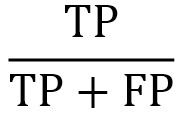
Precision is the percent of selected items that are correct.
1. Which model does better (has the bigger percentage)?
2. Is there a big difference between the two percentages or are they close?
3. What does that tell you?


### Recall
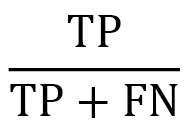
Recall is the percent of correct items that are selected.
1. Which model does better (has the bigger percentage)? 

2. Is there a big difference between the two percentages or are they close?

3. What does that tell you?

### Answers

Precision
1. For precision, the fine tuned has high precision than one shot.
2. The fine tuned model performs significanlty better that one shot in most cases.
3. Essentially for large data finetuning is better than one shot for more accurate results. For better precision finetuning is useful. 

Recall
1. In recall finetuning performs way better than one shot.
2. The difference between them is very noticible and fine tuning is far better than one shot.
3. This suggest fine tuned model gives more correct items and gives less false positives. Fine tuned model has significantly higher recal.